In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from scipy import stats
#data = pd.read_csv('data/res.csv')
data = pd.read_excel('data/results.xlsx')

pd.set_option('display.max_columns',200)

In [2]:
data.head(2)

,Timestamp,Курс,Стать (бінарна),ТЙМС,Предмет#2,"Назва предмету, який вважаєш проф-орієнтованим",Предмет#3,"1. Коли починаю будь-яку роботу, як правило, сподіваюся на успіх",2. Під час діяльності виявляю активність,3. Маю схильність до виявлення ініціативи\t,"4. Під час виконання відповідальних завдань намагаюся, якщо це можливо, знайти причини відмовитися від них","5. Часто обираю крайнощі: або надто легкі, або занадто важкі завдання","6. Якщо зустрічаю перешкоди, як правило, не відступаю, а шукаю можливості їх подолання\t","7. Коли успіхи і невдачі трапляються впереміжку, більше звертаю увагу на успіхи, а невдачами нехтую","8. Продуктивність діяльності переважно залежить від моєї власної цілеспрямованості, працьовитості, а не від зовнішніх причин","9. Коли завдання складні, а часу мало, результат діяльності погіршується\t",10. Я зазвичай наполегливий у досягненні мети,11. Планую своє майбутнє на достатньо віддалену перспективу,"12. Якщо ризикую, то скоріше обдумано","13. Не дуже наполегливий у досягненні мети, особливо, якщо відсутній зовнішній контроль","14. Волію ставити перед собою середні або злегка завищені завдання, які реально можу виконати\t","15. Якщо під час виконання будь-якого завдання мене спіткає невдача, воно стає для мене менш привабливим\t","16. Коли успіхи і невдачі трапляються впереміжку, більше звертаю уваги на невдачі \t",17. Планую своє майбутнє лише на найближчий час \t,"18. Я досягаю кращих результатів, коли час виконання обмежений, навіть якщо завдання досить складне\t",19. Не відмовляюсь від поставленої мети навіть у разі невдачі під час виконання будь-якої роботи \t,"20. Якщо завдання я обирав сам, тоді у разі невдачі воно ще більше мене приваблює\t","#1. Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. [Рівняння мат. фізики]","#1. Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. [Технології прикладного програмування]","#1. Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. [Аналіз даних]","#2. Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. [Рівняння мат. фізики]","#2. Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. [Технології прикладного програмування]","#2. Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. [Аналіз даних]","#3. У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. [Рівняння мат. фізики]","#3. У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. [Технології прикладного програмування]","#3. У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. [Аналіз даних]","#4. Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. [Рівняння мат. фізики]","#4. Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. [Технології прикладного програмування]","#4. Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. [Аналіз даних]","#5. Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. [Рівняння мат. фізики]","#5. Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. [Технології прикладного програмування]","#5. Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. [Аналіз даних]",#6. При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу [Рівняння мат. фізики],#6. При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу [Технології прикладного програмування],#6. При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу [Аналіз даних],"#7. Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. [Рівнянн

1) В рамках тесту 1 сформулювати задачу розподілу мотивацій для свого курсів як задачу перевірки статистичних гіпотез про розподіл даних,  розв’язати вручну (Excel)  використати критерій Пірсона

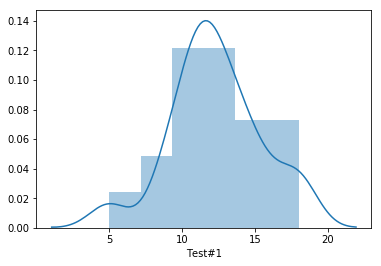

In [3]:
test1 = data[data['Курс']==4]['Test#1']
sns.distplot(test1)

In [20]:
bins = np.arange(0,20,5)
mapped_bins = np.digitize(test1,bins,right=False)
grouped_test1 = test1.groupby(by=mapped_bins).count()
grouped_test1[1]=0
grouped_test1.sort_index(inplace=True)

test1_data = pd.DataFrame(np.array([bins,grouped_test1.values]).T,columns=['interval','freq'])
test1_h,test1_c = 5,7.5
test1_data

,interval,freq
0,0,0
1,5,3
2,10,12
3,15,4


Observed frequencies:

Chi squared custom calculator

In [14]:
class Xi_squared_calculator:
    def calculate_x_dash(self,x):
        return (x-self.c)/self.h
    
    def __init__(self,data, h, c):
        """
            data -- pd.DataFrame [interval, freq]
        """
        self.data = data
        self.h,self.c = h,c

        self.size = self.data.freq.sum()
        self.data_transformed = self.transform_data()
        
        self.dash_mean, self.dash_var = self.dash_moments()
        self.empirical_mean, self.empirical_var, self.empirical_std = self.empirical_moments()
        
        self.tf_df = self.theoretical_freq_table()#theoretical freq
        self.chi_df = self.chi_observed_table()
        
        self.chi_approx = self.chi_df.chi.sum()
        
    def transform_data(self):
        data_transformed = self.data.assign(
            x_dash=lambda x: self.calculate_x_dash(x.interval),
            x_dash_freq = lambda x: x.x_dash*x.freq,
            x_dash_freq_squared = lambda x: x.x_dash_freq * x.x_dash)        
        return data_transformed
        
    def dash_moments(self):
        dash_mean = self.data_transformed.x_dash_freq.sum()/self.size
        dash_var = self.data_transformed.x_dash_freq_squared.sum()/self.size - dash_mean**2
        return dash_mean,dash_var
    
    def empirical_moments(self):
        empricial_mean = self.dash_mean * self.h + self.c
        empirical_var = self.dash_var * self.h**2
        return empricial_mean,empirical_var, np.sqrt(empirical_var)
            
    def theoretical_freq_table(self):
        k = self.size * self.h / self.empirical_std
        tf_df = pd.DataFrame(self.data.interval)
        tf_df = tf_df.assign(
            u = lambda x: (x - self.empirical_mean) / self.empirical_std,
            phi = lambda x: stats.norm.pdf(x.u),
            n_i = lambda x: k * x.phi)
        return tf_df
    
    def chi_observed_table(self):
        chi_df = pd.DataFrame(np.array([self.data_transformed.freq, self.tf_df.n_i]).T, columns=['observed_freq','theor_freq'])
        chi_df = chi_df.assign(
            diff = lambda x: (x.observed_freq - x.theor_freq),
            diff_squared =  lambda x: x['diff'] **2,
            chi = lambda x: x.diff_squared / x.theor_freq)        
        return chi_df
    
    
    def get_chi_approx(self):
        return self.chi_approx

In [15]:
#Example:
test_df =  pd.DataFrame(np.array([np.arange(5,22,2),np.array([15,26,25,30,26,21,24,20,13])]).T, columns=['interval','freq'])

c2p = Xi_squared_calculator(test_df,2,13)
print(f'custom chi_2={c2p.chi_approx}')
print(f'Scipy stats alternative: {stats.chisquare(c2p.chi_df.observed_freq,c2p.chi_df.theor_freq,ddof = 3)}')
print(f'chi^2_critical = {stats.chi2.ppf(0.95,9-3)}')

custom chi_2=22.424820220293732
Scipy stats alternative: Power_divergenceResult(statistic=22.424820220293732, pvalue=0.0004346526839824956)
chi^2_critical = 12.591587243743977


In [18]:
c2p = Xi_squared_calculator(test1_data,test1_h,test1_c)
print(f'chi^2_observed = {c2p.chi_approx} with chi_2_critical={stats.chi2.ppf(0.95,1)}')
stats.chisquare(c2p.chi_df.observed_freq, c2p.chi_df.theor_freq,ddof=3)

chi^2_observed = 0.10923905413393467 with chi_2_critical=3.841458820694124


Power_divergenceResult(statistic=0.10923905413393467, pvalue=nan)

2) В рамках тесту 2 сформулювати задачу порівняння мотивацій для різних курсів як задачу перевірки статистичних гіпотез про однорідність даних, розв’язати вручну (Excel), використати: 
*  Т-критерій Стьюдента 
*  критерій знаків 
*  критерій Вілкоксона та  Мана-Уітні.

3) висновок в предметній області.
